# Принятие решений в бизнесе
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

### Описание данных

<ul>Структура hypothesis.csv:
    <li>Hypothesis — краткое описание гипотезы,</li>
    <li>Reach — охват пользователей по 10-балльной шкале,</li>
    <li>Impact — влияние на пользователей по 10-балльной шкале,</li>
    <li>Confidence — уверенность в гипотезе по 10-балльной шкале,</li>
    <li>Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.</li>
</ul> 
<ul>Структура orders.csv:
    <li>transactionId — идентификатор заказа,</li>
    <li>visitorId — идентификатор пользователя, совершившего заказ,</li>
    <li>date — дата, когда был совершён заказ</li>
    <li>revenue — выручка заказа</li>
    <li>group — группа A/B-теста, в которую попал заказ</li>
</ul>
<ul>Структура visitors.csv:
    <li>date — дата,</li>
    <li>group — группа A/B-теста,</li>
    <li>visitors — количество пользователей в указанную дату в указанной группе A/B-теста.</li>
</ul>

### Предобработка данных 

In [1]:
import pandas as pd
from scipy import stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
try: 
    visitors=pd.read_csv('visitors.csv')
    orders=pd.read_csv('orders.csv')
    hypothesis=pd.read_csv('hypothesis.csv')
except:
    visits=pd.read_csv('/datasets/visitors.csv')
    orders=pd.read_csv('/datasets/orders.csv')
    hypothesis=pd.read_csv('/datasets/hypothesis.csv')

Проверили таблицу hypothesis на наличие пропусков и дубликатов. Перевели названия столбов в нижний регистр.

In [2]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
print('Количество пропусков в столбцах:')
hypothesis.isna().sum()

Количество пропусков в столбцах:


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

In [5]:
print('Количество дубликатов:', hypothesis.duplicated().sum())

Количество дубликатов: 0


In [6]:
hypothesis.columns=['hypothesis','reach','impact','confidence','efforts']

In [7]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Проверили таблицу visitors на наличие пропусков и дубликатов. Привели столбец 'date' к формату datetime.

In [8]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [10]:
print('Количесвто пропусков в столбцах:')
print(visitors.isna().sum())
print(f'Количесвто дубликтов-{visitors.duplicated().sum()}')
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Количесвто пропусков в столбцах:
date        0
group       0
visitors    0
dtype: int64
Количесвто дубликтов-0


Проверили таблицу orders на наличие пропусков и дубликатов. Перевели название столбов в 'змеиный' регистр. Привели столбец 'date' к формату datetime.

In [11]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [12]:
print('Количесвто пропусков в столбцах:')
print(orders.isna().sum())
print(f'Количесвто дубликтов-{orders.duplicated().sum()}')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Количесвто пропусков в столбцах:
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
Количесвто дубликтов-0


In [13]:
orders.rename(columns={'transactionId':'transaction_id','visitorId':'visitor_id'},inplace = True )
orders.head(10)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


### Часть 1. Приоритизация гипотез.

1.1 Применили фреймворк ICE для для приоритизации гипотез. Отсортировали их по убыванию приоритета.

In [14]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
hypothesis['ICE']=(hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis['ICE']=round(hypothesis['ICE'],2)
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


1.2 Применили фреймворк RICE для для приоритизации гипотез. Отсортировали их по убыванию приоритета.

In [15]:
hypothesis['RICE']=(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False)


,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Вывод:
<ul>
    <li>По фреймворку ICE приоритенее оказались гипотезы 8(Запустить акцию, дающую скидку на товар в день рождения), 0(Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей) и 7(Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок).</li>
    <li>По фреймворку RICE приоритенее оказались гипотезы 7(Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок), 2(Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа) и 0(Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей)</li>
</ul>
На различия в приоритетах повлиял критерий Reach(скольких пользователей затронет изменение, которое вы хотите
внести), так как этот критерий важен дла анализа, в нашем случае приоритетными гипотезами будут 7,2, 0. 

### Часть 2. Анализ A/B-теста

Проверили корректность распределения на группы A/B

In [16]:
print(f'Количесвто посетителей в группе А-',visitors[visitors['group']=='A']['visitors'].sum())
print(f'Количесвто посетителей в группе B-',visitors[visitors['group']=='B']['visitors'].sum())
pura=orders[orders['group']=='A']['revenue'].count()
purb=orders[orders['group']=='B']['revenue'].count()
print(f'Количесвто покупак в группе А-{pura}')
print(f'Количесвто покупак в группе B-{purb}')

alpha =0.05
results =  st.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])
print('p-значение: ', round(results.pvalue,2))
if results.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима')
else:
    print(
        'Разница в количестве посетителей в группах A и B статистически не значима'
    ) 

Количесвто посетителей в группе А- 18736
Количесвто посетителей в группе B- 18916
Количесвто покупак в группе А-557
Количесвто покупак в группе B-640
p-значение:  0.73
Разница в количестве посетителей в группах A и B статистически не значима


In [17]:
start_conv=pura/visitors[visitors['group']=='A']['visitors'].sum()*100
fix_conv=purb/visitors[visitors['group']=='B']['visitors'].sum()*100
print(f'Начальная конверсия-{round(start_conv,0)}%')
print(f'Конверсия после изменений-{round(fix_conv,0)}%')
print('Относительное изменение конверсии после изменений: {:.0f}%'.format(abs(1-(start_conv/fix_conv))*100))
print('\n')
print('Для расчета размеры выборки используем https://www.evanmiller.org/ab-testing/sample-size.html\n'
     'Размер выборки-35855')
print('В нашем случае', visitors['visitors'].sum())

Начальная конверсия-3.0%
Конверсия после изменений-3.0%
Относительное изменение конверсии после изменений: 12%


Для расчета размеры выборки используем https://www.evanmiller.org/ab-testing/sample-size.html
Размер выборки-35855
В нашем случае 37652


Размер выборки подобран правильно, приступаем в A/B тестированию

Проверили, есть ли пользователи, которые попали в обе группы. 

In [18]:
orders.groupby('visitor_id')['group'].unique()

visitor_id
5114589          [B]
6958315          [B]
8300375       [B, A]
11685486         [A]
39475350         [B]
               ...  
4266935830    [A, B]
4278982564       [A]
4279090005       [B]
4281247801       [B]
4283872382       [B]
Name: group, Length: 1031, dtype: object

In [19]:
users_in_group = orders.groupby('visitor_id')['group'].nunique()
print('Количесвто пользователй, попавшие в обе группы:',(users_in_group > 1).sum())
print('Процетное содержание людей, находящихся в обеих группах',((users_in_group > 1).sum()/users_in_group.shape[0])*100)

Количесвто пользователй, попавшие в обе группы: 58
Процетное содержание людей, находящихся в обеих группах 5.625606207565471


Данных пользователй удалим для корректного анализа. 

In [20]:
users_in_both=users_in_group[users_in_group > 1].index
orders = orders[np.logical_not(orders['visitor_id'].isin(users_in_both))]

2.1. Построили график кумулятивной выручки по группам

In [21]:
datesGroups=orders[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


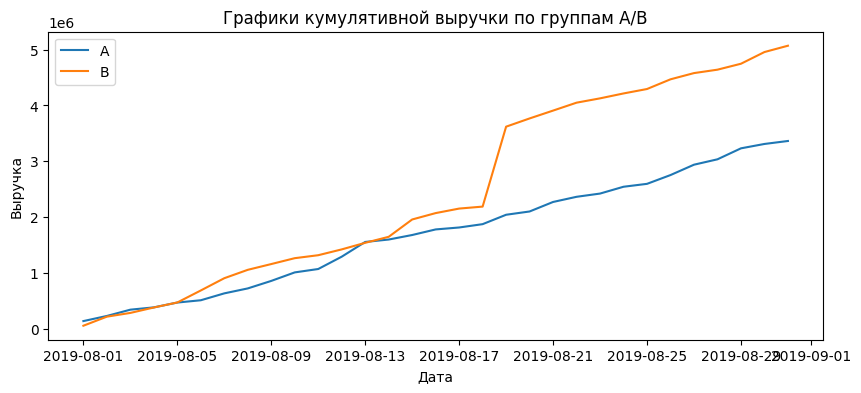

In [22]:
import matplotlib.pyplot as plt
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A']
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(10,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики кумулятивной выручки по группам A/B')
plt.legend()
plt.show()

Группа B показывает вырочку больше на протяжение всего периода, однако во второй половине заметно резкое повышение, появляется вероятность аномалий.

2.2. Построили график кумулятивного среднего чека по группам.

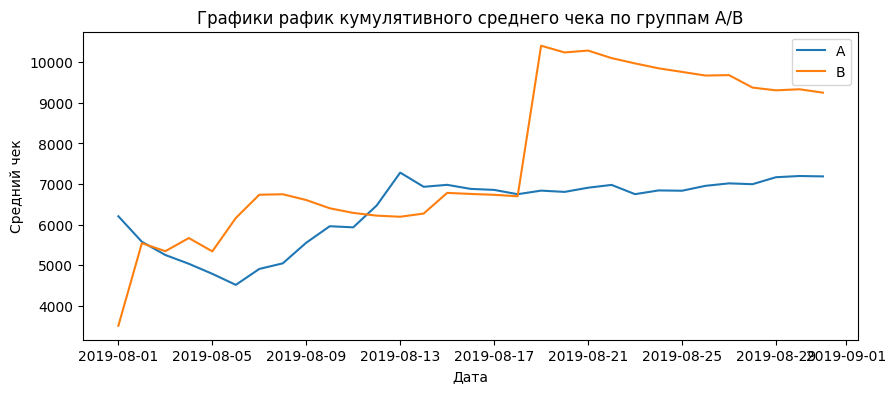

In [23]:
plt.figure(figsize=(10,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.title('Графики рафик кумулятивного среднего чека по группам A/B')
plt.legend()
plt.show()

По графику видно, что средний чек группы B выше на протяжение всего времени, однако во второй половине заметно резкое повышение, появляется вероятность аномалий.

2.3. Построили график относительного изменения кумулятивного среднего чека группы B к группе A.

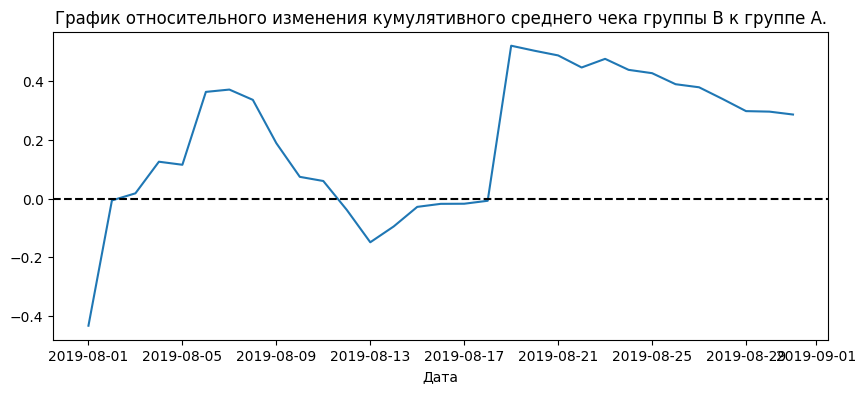

In [24]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,4))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A.')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

В некоторых точках график различия между сегментами резко «скачет». Где-то есть крупные заказы и выбросы.

2.4. Построили график кумулятивного среднего количества заказов на посетителя по группам.

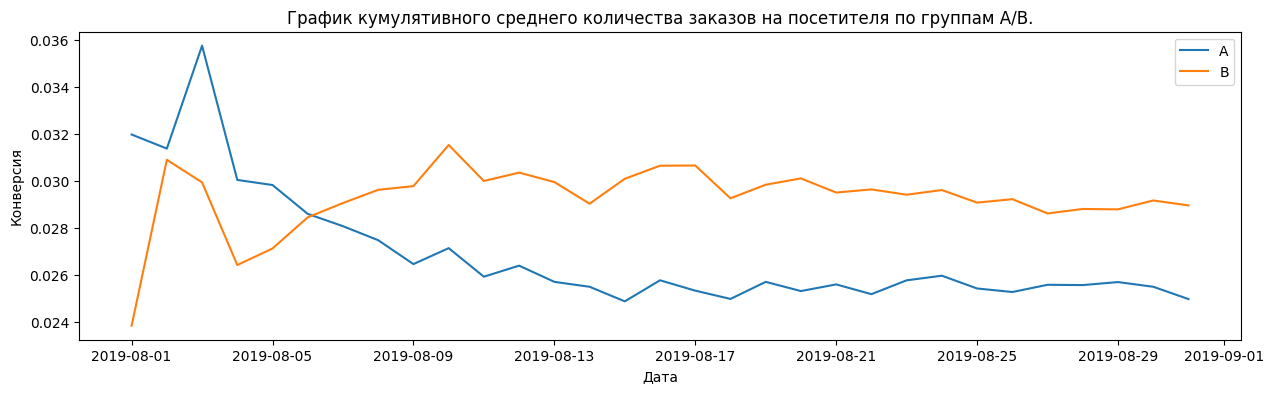

In [25]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(15,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам A/B.')
plt.legend()

Конверсия группы B значительно выше на протяжение длительного времени.

2.5. Построилии график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

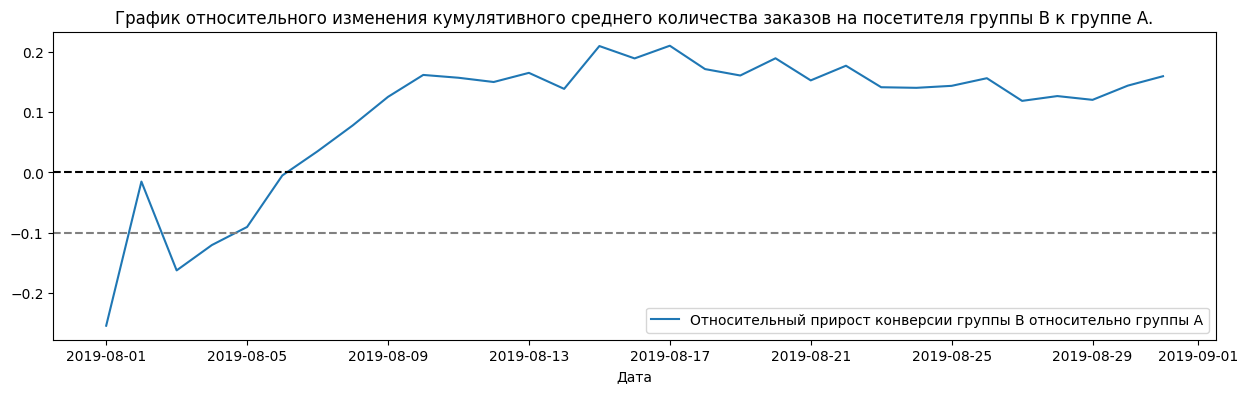

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,4))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.')
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

В начале теста группа В проигровала по конверсии группе А, затем стала повышаться.

2.6. Построили точечный график количества заказов по пользователям.

Text(0.5, 1.0, 'Гистрограмма распределения количества заказов на одного пользователя.')

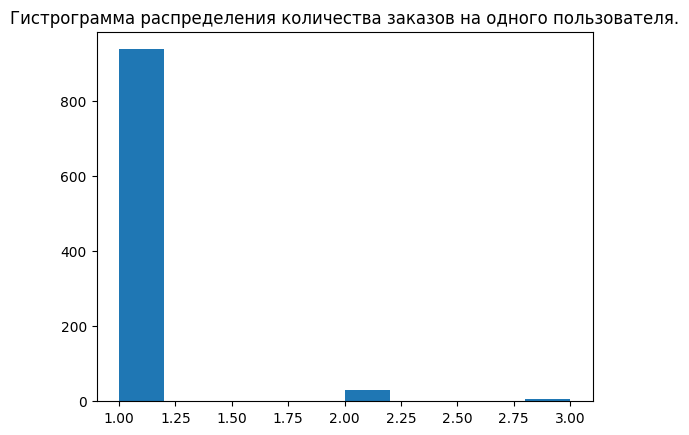

In [27]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']
plt.hist(ordersByUsers['orders']) 
plt.title('Гистрограмма распределения количества заказов на одного пользователя.')

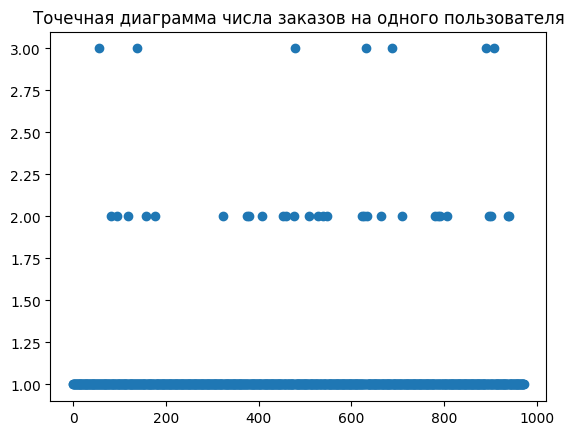

In [28]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.show()

Большинство пользоватей не совершают больше двух заказов.

2.7. Посчитали 95-й и 99-й перцентили количества заказов на пользователя. Выбрали границу для определения аномальных пользователей.

In [29]:
print('Перцентили')
percentiles_orders=np.percentile(ordersByUsers['orders'], [95, 99])
print('95-', percentiles_orders[0])
print('99-', percentiles_orders[1])

Перцентили
95- 1.0
99- 2.0


Только 5% пользователй совершают больше одного заказов. Верхней границей для пользователей выбираем 2, остальное количесво заказов считаем аномальным.

2.8 Построили точечный график стоимостей заказов

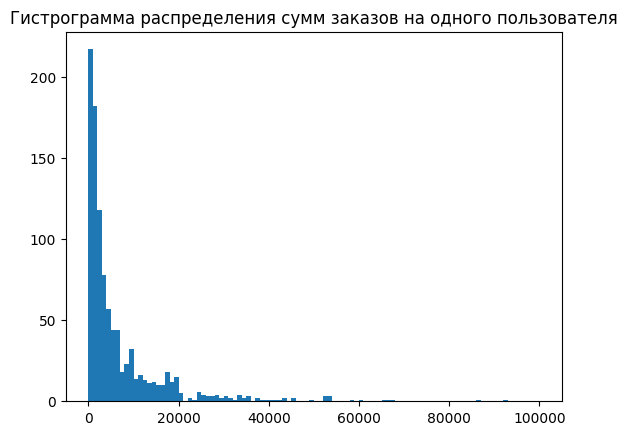

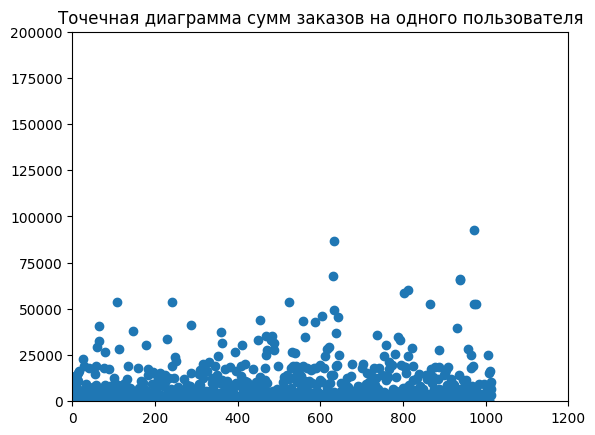

In [30]:
plt.hist(orders['revenue'], range=(0,100000), bins = 100)
plt.title('Гистрограмма распределения сумм заказов на одного пользователя')
plt.show()
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечная диаграмма сумм заказов на одного пользователя')
plt.axis([0, 1200, 0, 200000])
plt.show()

В основном пользователи совершают заказы на сумму 15-25 тыс. рублей.

In [31]:
print('Перцентили')
percentiles_revenue=np.percentile(orders['revenue'], [95, 99])
print('95-', round(percentiles_revenue[0],0))
print('99-', round(percentiles_revenue[1],0))

Перцентили
95- 26785.0
99- 53904.0


Только 5% пользователей совершают заказ больше, чем на 26785 рублей.  Верхней границей для пользоватлей выбираем 26785 рублей, остальное считаем аномальным.

2.9. Посчитали статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

H0: Конверсия в группе A равна конверсии в группе B

H1: Конверсия в группе A НЕ равна конверсии в группе B

In [41]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

In [42]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
data=visitorsADaily.merge(visitorsBDaily, left_on='date', right_on='date', how='left')

In [43]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [44]:
alpha=0.05
print("Относительный прирост среднего числа заказов группы B к группе А -{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
results = st.mannwhitneyu(sampleA, sampleB)
print('p-value: {}'.format(results.pvalue)) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Относительный прирост среднего числа заказов группы B к группе А -0.160
p-value: 0.011018084110014696
Отвергаем нулевую гипотезу


В конверсии между группами есть статистически значимые различия по «сырым» данным.

2.10 Посчитали статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

H0: различий в среднем чеке между группами нет. 

H1: различия в среднем чеке между группами есть. 

In [45]:
print('Относительное изменение среднего чека в группе B по отношению группы A: {:.3f}'.format(
orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('p-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Относительное изменение среднего чека в группе B по отношению группы A: 0.287
p-value: 0.8294908998149533
Не получилось отвергнуть нулевую гипотезу


Нет статистически значимых различий в среднем чеке заказа между группами по «сырым» данным.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Совершенно верно!</div>

2.11. Посчитали статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

H0: Конверсия в группе A равна конверсии в группе B

H1: Конверсия в группе A НЕ равна конверсии в группе B

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Гипотезы сформулированы</div>

In [46]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > percentiles_orders[1]]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > percentiles_orders[1]]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > percentiles_revenue[0]]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print('Всего {} аномальных пользователей.'.format(abnormalUsers.shape[0]))

Всего 58 аномальных пользователей.


<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Лучше не указывать числа напрямую, а обращаться к ним через перцентиль. В таком случае, если данные изменятся нам не нужно будет корректировать код

<div class="alert alert-success">
<b>Комментарий ревьюера v 2.0 ✔️:</b> И автоматизацию при проведении фильтрации тоже повысили

In [47]:
sampleAFiltered = pd.concat([
    ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],
   pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat([
    ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],
    pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [48]:
alpha=0.05
print("Относительный прирост среднего числа заказов группы B к группе А :{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))
results = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('p-value: {}'.format(results.pvalue)) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Относительный прирост среднего числа заказов группы B к группе А :0.182
p-value: 0.01235203801772639
Отвергаем нулевую гипотезу


В конверсии между группами есть статистически значимые различия по по «очищенным» данным, также как по «сырым» данным.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> И здесь по формулировке снова все абсолютно корректно</div>

2.12. Посчитали статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

H0: различий в среднем чеке между группами нет. 

H1: различия в среднем чеке между группами есть. 

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Хорошо, но ниже мы проверяем не конверсии

<div class="alert alert-success">
<b>Комментарий ревьюера v 2.0 ✔️:</b> Отлично!

In [49]:
print('Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: {:.3f}'.format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()\
/orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()-1))
results = st.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])
print('p-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: -0.048
p-value: 0.6458964038091206
Не получилось отвергнуть нулевую гипотезу


Нет статистически значимых различий в среднем чеке заказа между группами по «очищенным» данным, как и  по «сырым» данным.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> А по самому выводу также все корректно</div>

### Вывод
<ul>
    <li>В конверсии между группами есть статистически значимые различия по по «очищенным» данным, также как по «сырым» данным</li>
    <li>Нет статистически значимых различий в среднем чеке заказа между группами по «очищенным» данным, как и по «сырым» данным.</li>
<ul>
Останавливаем тест и фиксируем победу группы B, так как кумулятивные метрики по выручке, среднему чеку и конверсии лидировали в группе B.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Общий вывод сформулирован классно. Все по пунктам и есть решение по самому результату проведения</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Таисия, еще один отличный проект! Продемонстрировала хорошие навыки аналитики, понимание статистики и навыки оценки параметров из продуктовой аналитики. Но всё же в проекте есть буквально одно критическое замечание и я попрошу тебя исправить его, чтобы проект стал еще лучше! </div>